# Scoring well on chessable.com
In this project we will focus on how to get the most from a chessable course. The aim will be to crawl into the skin of a chess professional and find out which course they should make to get the most out of the platform.

There are 23 relevant columns  
1: **course_link**  
2: **course_title**  
3: **course_type** -- This field specifies about which field the course is about. Opening, Tactics, Strategy, Endgame or a combination. There is also a bundle option.  
4: **author** -- The author of the course, which can be a real name or an alias. This field also includes their chess titles: NM, CM, FM, IM, GM and women titles with a W in front of it.  
5: **price** -- Course price in €.  
6: **price_with_video** -- Price in € for additional video material. Contains missing values.  
7: **course_rating** -- Ratings based on a five star system.  
8: **course_rating_count** -- The amount of ratings per course.  
9: **rubies** -- The amount of rubies donated to a course. One Ruby = \\$0.05  
10: **target_color** -- The color at which the course is aimed: black, white or both.  
11: **beginning** -- The following five columns represent the target audience rating: ELO 800 - 1000  
12: **casual** -- ELO 1000 - 1400  
13: **intermediate** -- ELO 1400 - 1800  
14: **advanced** -- ELO 1800 - 2100  
15: **expert** -- ELO 2000 - 2400  
16: **language**  
17: **instruction_word_count** -- The amount of feedback in words per course.  
18: **free_video** -- The duration of free video available.  
19: **trainable_variations** -- The amount of variations with feedback-training.  
20: **avg_line_depth** -- The average amount of moves per variation.  
21: **released_on** -- The releasedate of the course.  
22: **support_level**  
23: **section** -- This field describes the nature of the contributor: Titled player, Community or Publisher.  

## The target

The target is not easily defined yet. One can focus on average rating, rating counts or even rubies (donations). For free courses, the amount of rubies is more important in a sense that the author would make more. At least that's what one would think. The donations in rubies do not go to the authors themselves. They go to the platform chessable. 

Therefore it is safe to say that the best column to select as our target would be **course_rating_count**. One can only vote on a paid course when one has actually paid for the course, so that is a sure sign of purchase. 

## The method

In this investigation we will first do some exploratory data analysis after some minor cleaning. After that we will try to train a simple linear model to select the best features for our analysis. Those will be the *features* to answer our initial question. What kind of courses are successful on chessable?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression

chessable = pd.read_csv("chessable_clean_30072020.csv", index_col = False)
chessable.head()

,Unnamed: 0,course_link,course_title,course_type,author,price,price_with_video,course_rating,course_rating_count,rubies,...,advanced,expert,language,instruction_word_count,free_video,trainable_variations,avg_line_depth,released_on,support_level,section
0,0,short-sweet-legendary-tactics/course/47106/,Short & Sweet: Legendary Tactics,Tactics/Strategy course,GM GM Pascal Charbonneau,0.0,NaN,4.7,30,14,...,1,1,English,"1,212",1 hour and 59 minutes,24,9.29,"Jul 24, 2020",High,Titled player
1,1,chessable-masters-tournament/course/43805/,Chessable Masters Tournament,Tactics/Strategy course,Chessable,0.0,NaN,4.5,88,59,...,1,0,English,126,4 hours and 31 minutes,65,16.36,"Jun 21, 2020",High,Titled player
2,2,short-sweet-the-black-lion/course/35086/,Short & Sweet: The Black Lion,Opening course,GM GingerGM,0.0,NaN,4.7,198,119,...,0,0,English,"6,210",1 hour and 5 minutes,24,13.63,"Mar 11, 2020",High,Titled player
3,3,short-and-sweet-jan-gustafssons-1-e4-e5/course...,Short and Sweet: Jan Gustafsson's 1. e4 e5,Opening course,Chessable,0.0,NaN,4.6,242,123,...,0,0,English,"9,820",NaN,37,17.00,"Dec 13, 2019",High,Community
4,4,short-sweet-queens-gambit-declined/course/34082/,Short & Sweet: Queen's Gambit Declined,Opening course,GM Alex Colovic,0.0,NaN,4.4,73,44,...,0,0,English,"3,932",38 minutes,20,15.83,"Jun 19, 2020",High,Titled player


In [2]:
#making some last cleaning efforts
chessable['released_on'] = pd.to_datetime(chessable['released_on'])
chessable = chessable.drop("Unnamed: 0", axis = 1)
chessable.course_type = chessable.course_type.str[:-7] #Deleting the 'course' after every word.
chessable.rubies = chessable.rubies.str.replace(',','').astype('int')
chessable.instruction_word_count = chessable.instruction_word_count.str.replace(',','').astype('int')

In [3]:
#Cleaning the times
import re

def p_time(val):
    try:
        t = 0
        h = re.search(r"(\d+) hour(s)?", val)
        if h:
            t += int(h.group(1)) * 60
        m = re.search(r"(\d+) minute(s)?", val)
        if m:
            t += int(m.group(1))
        return t
    except:
        pass
    return 0

chessable['free_video_minutes'] = chessable['free_video'].apply(p_time)
chessable = chessable.drop('free_video',axis=1)
chessable['free_video_minutes'].head()

0    119
1    271
2     65
3      0
4     38
Name: free_video_minutes, dtype: int64

In [4]:
chessable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   course_link             376 non-null    object        
 1   course_title            376 non-null    object        
 2   course_type             376 non-null    object        
 3   author                  376 non-null    object        
 4   price                   376 non-null    float64       
 5   price_with_video        264 non-null    float64       
 6   course_rating           376 non-null    float64       
 7   course_rating_count     376 non-null    int64         
 8   rubies                  376 non-null    int32         
 9   target_color            376 non-null    object        
 10  beginning               376 non-null    int64         
 11  casual                  376 non-null    int64         
 12  intermediate            376 non-null    int64     

In [5]:
chessable.corr().style.background_gradient(cmap='coolwarm')

,price,price_with_video,course_rating,course_rating_count,rubies,beginning,casual,intermediate,advanced,expert,instruction_word_count,trainable_variations,avg_line_depth,free_video_minutes
price,1.000000,0.645826,-0.024621,-0.174291,0.191886,-0.318878,0.009787,0.069276,0.400493,0.417311,0.663414,0.386647,-0.035307,0.249105
price_with_video,0.645826,1.000000,0.058513,0.154836,0.292484,-0.199988,-0.006316,0.019805,0.152345,0.268344,0.264580,0.070272,0.058044,0.735925
course_rating,-0.024621,0.058513,1.000000,0.102799,0.109979,0.034247,0.132108,-0.010758,0.020354,-0.077024,-0.093359,0.032561,-0.029969,0.075469
course_rating_count,-0.174291,0.154836,0.102799,1.000000,0.599349,0.111114,-0.016907,-0.120438,-0.211728,-0.129793,-0.074153,-0.049444,-0.123248,0.130719
rubies,0.191886,0.292484,0.109979,0.599349,1.000000,-0.051866,-0.030998,0.024173,0.022247,0.043293,0.141802,0.161139,-0.069960,0.222319
beginning,-0.318878,-0.199988,0.034247,0.111114,-0.051866,1.000000,0.407108,-0.201169,-0.589350,-0.392193,-0.285474,0.064259,-0.087189,-0.054396
casual,0.009787,-0.006316,0.132108,-0.016907,-0.030998,0.407108,1.000000,0.061318,-0.036761,-0.111791,-0.041500,0.091440,-0.017539,0.131702
intermediate,0.069276,0.019805,-0.010758,-0.120438,0.024173,-0.201169,0.061318,1.000000,0.322735,0.136824,0.079933,0.045592,0.260466,0.091842
advanced,0.400493,0.152345,0.020354,-0.211728,0.022247,-0.589350,-0.036761,0.322735,1.000000,0.444822,0.295452,-0.008787,0.163187,0.099556
expert,0.417311,0.268344,-0.077024,-0.129793,0.043293,-0.392193,-0.111791,0.136824,0.444822,1.000000,0.375702,0.053415,-0.028796,0.181515


## Correlations
From the above heatmap there are several things that interest us. 
* course_rating_count hardly correlates with any column except for rubies, which was to be expected. Of course the donations giveaway the fact if someone has bought the course. 
* The price correlates mostly with the amount of trainable variations and the level. Courses for advanced and expert level are more expensive.

One conclusion to draw here is that we should not use a linear model to predict the amount of ratings. So, now we can go on with extracting new features from the string columns. 

## Feature engineering 
Two obvious features to extract are:
* The titles from the author's names
* The course types, by using one hot encoding.

In [6]:
chessable['titled_author'] = 'no title'  #Let's hope no author lied about their titles!
chessable.loc[chessable['author'].str.contains(r'^GM'), 'titled_author'] = 'GM'
chessable.loc[chessable['author'].str.contains(r'WGM'), 'titled_author'] = 'WGM'
chessable.loc[chessable['author'].str.contains(r'^IM'), 'titled_author'] = 'IM'
chessable.loc[chessable['author'].str.contains(r'WIM'), 'titled_author'] = 'WIM'
chessable.loc[chessable['author'].str.contains(r'^FM'), 'titled_author'] = 'FM'
chessable.loc[chessable['author'].str.contains(r'WFM'), 'titled_author'] = 'WFM'
chessable.loc[chessable['author'].str.contains(r'^CM'), 'titled_author'] = 'CM'
chessable.loc[chessable['author'].str.contains(r'WCM'), 'titled_author'] = 'WCM'
chessable['titled_author'].value_counts()

no title    184
GM           73
IM           58
FM           48
CM            7
WFM           5
WIM           1
Name: titled_author, dtype: int64

In [7]:
dummy_course_types = pd.get_dummies(chessable['course_type'], prefix= 'type')
chessable = pd.concat([chessable,dummy_course_types],axis = 1)

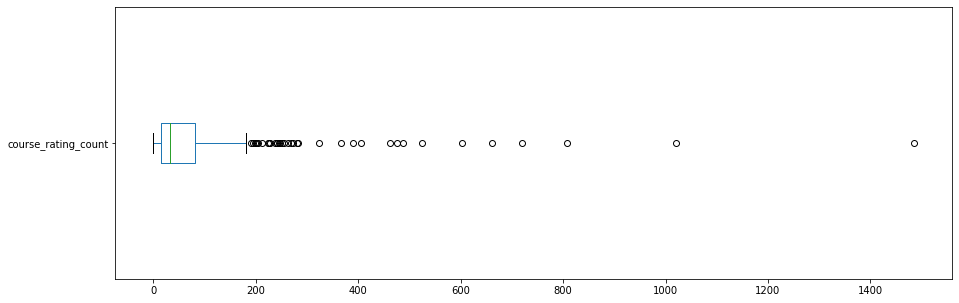

In [8]:
chessable.course_rating_count.plot.box(figsize=(15,5),vert=False) #checking the distribution. There are just a few outliers. 

In [9]:
chessable.corr().style.background_gradient(cmap='coolwarm')

,price,price_with_video,course_rating,course_rating_count,rubies,beginning,casual,intermediate,advanced,expert,instruction_word_count,trainable_variations,avg_line_depth,free_video_minutes,type_Endgame,type_Endgame/Tactics,type_Opening,type_Opening/Tactics,type_Strategy,type_Strategy/Endgame,type_Strategy/Opening,type_Strategy/Tactics,type_Tactics,type_Tactics/Endgame,type_Tactics/Opening,type_Tactics/Strategy
price,1.000000,0.645826,-0.024621,-0.174291,0.191886,-0.318878,0.009787,0.069276,0.400493,0.417311,0.663414,0.386647,-0.035307,0.249105,-0.041075,0.068666,-0.213341,0.147475,-0.021659,0.090363,0.034491,0.161759,0.036102,0.075024,0.034491,0.109330
price_with_video,0.645826,1.000000,0.058513,0.154836,0.292484,-0.199988,-0.006316,0.019805,0.152345,0.268344,0.264580,0.070272,0.058044,0.735925,-0.085364,0.015690,0.160831,0.069027,0.063665,0.127953,-0.019241,0.034160,-0.225630,-0.052276,0.009193,0.025001
course_rating,-0.024621,0.058513,1.000000,0.102799,0.109979,0.034247,0.132108,-0.010758,0.020354,-0.077024,-0.093359,0.032561,-0.029969,0.075469,0.058471,0.047895,-0.026030,-0.058052,-0.003224,0.033821,-0.042214,0.027110,0.010915,0.030986,0.014813,-0.028290
course_rating_count,-0.174291,0.154836,0.102799,1.000000,0.599349,0.111114,-0.016907,-0.120438,-0.211728,-0.129793,-0.074153,-0.049444,-0.123248,0.130719,0.236893,-0.033798,0.022961,-0.039249,-0.039151,-0.024434,-0.027080,-0.043385,-0.028548,-0.048042,-0.025946,-0.044628
rubies,0.191886,0.292484,0.109979,0.599349,1.000000,-0.051866,-0.030998,0.024173,0.022247,0.043293,0.141802,0.161139,-0.069960,0.222319,0.184518,-0.024490,-0.034962,-0.008762,-0.040731,-0.016192,-0.025187,-0.026712,0.023717,-0.042433,-0.026105,-0.012288
beginning,-0.318878,-0.199988,0.034247,0.111114,-0.051866,1.000000,0.407108,-0.201169,-0.589350,-0.392193,-0.285474,0.064259,-0.087189,-0.054396,-0.038185,0.021929,-0.077842,0.015054,-0.066559,-0.038426,-0.038426,-0.029018,0.229406,-0.071233,0.069397,-0.108436
casual,0.009787,-0.006316,0.132108,-0.016907,-0.030998,0.407108,1.000000,0.061318,-0.036761,-0.111791,-0.041500,0.091440,-0.017539,0.131702,-0.069117,-0.041624,-0.146843,0.096110,0.024703,-0.088813,0.030026,-0.047286,0.185485,-0.041511,0.030026,0.034805
intermediate,0.069276,0.019805,-0.010758,-0.120438,0.024173,-0.201169,0.061318,1.000000,0.322735,0.136824,0.079933,0.045592,0.260466,0.091842,0.058929,0.021140,0.091563,0.047785,0.007993,0.014929,0.014929,0.004201,-0.103648,-0.026456,-0.178628,-0.059921
advanced,0.400493,0.152345,0.020354,-0.211728,0.022247,-0.589350,-0.036761,0.322735,1.000000,0.444822,0.295452,-0.008787,0.163187,0.099556,0.087134,-0.025546,-0.071287,0.047312,0.087134,0.036661,0.036661,0.050337,-0.109745,0.065629,-0.072739,0.099059
expert,0.417311,0.268344,-0.077024,-0.129793,0.043293,-0.392193,-0.111791,0.136824,0.444822,1.000000,0.375702,0.053415,-0.028796,0.181515,-0.037111,0.035445,-0.094210,0.006644,-0.006908,0.082416,-0.032356,0.188981,-0.087885,0.194353,-0.032356,0.105019


Again we do not see a lot of correlation with our new columns. Two other things to note:
* Opening courses have the deepest avg_line_depth
* Tactics are slightly more popular with beginning and casual levels
* Tactics courses have a shallow avg_line_depth

               course_rating_count
titled_author                     
WFM                      14.400000
CM                       26.428571
WIM                      36.000000
FM                       45.270833
GM                       70.465753
no title                 73.472826
IM                      132.534483


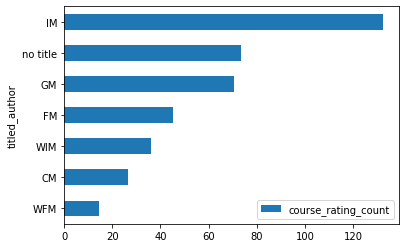

In [10]:
#Now we can see if the title matters.
#Defining a function for future pivot tables.
def rating_count_pivot(col):
    title_pivot = pd.pivot_table(chessable, values= 'course_rating_count', index= col).sort_values('course_rating_count', axis=0)
    print(title_pivot)
    return title_pivot.plot.barh()

rating_count_pivot('titled_author')

The results here are quite surprising, one would expect that the GM courses would perform better. On the other hand, Grandmasters often spend more time playing than creating teaching material. International masters can be full-time trainers and hence they will be more well-known as a teacher. 

For the rest it is interesting to see that no title is so high. Let's examine the section columns more closely

               course_rating_count
section                           
Community                60.671875
Publisher                66.488889
Titled player            95.354430


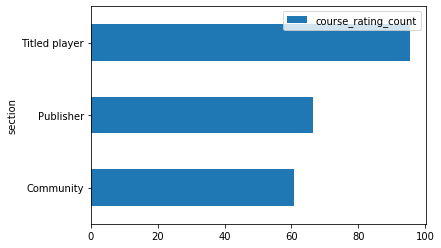

In [11]:
rating_count_pivot('section')

## Titled players score best
This is quite interesting, because publishers often create courses from books by, well, by titled players. However! If the players contribute it themselves the chances are larger that it will be a success. 

              course_rating_count
target_color                     
both pieces             66.312883
black pieces            71.407080
white pieces            99.380000


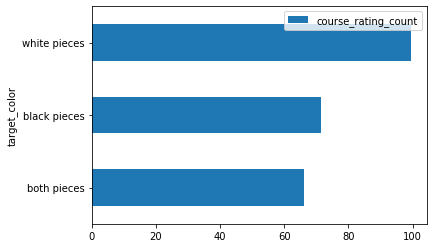

In [12]:
rating_count_pivot('target_color')

                                               course_rating_count
beginning casual intermediate advanced expert                     
0         0      0            1        0                 17.000000
                                       1                 24.000000
1         1      1            1        1                 36.666667
0         1      1            1        1                 48.907692
          0      1            1        1                 50.818182
          1      1            1        0                 57.875000
1         0      0            0        0                 58.000000
          1      1            1        0                 60.303030
0         0      1            1        0                 77.517241
                              0        0                 82.782609
          1      0            0        0                106.000000
1         1      0            0        0                107.666667
                 1            0        0                116.52

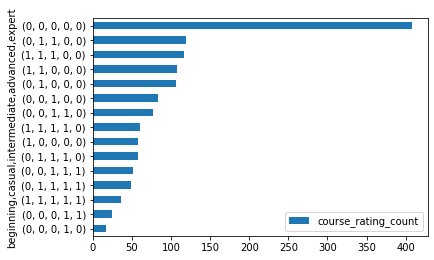

In [13]:
rating_count_pivot(['beginning','casual','intermediate','advanced','expert'])

## Course levels
The graph here is a little unclear however it gives the code possibilities to give the level. But the levels are just like they are presented in the table, beginning to expert from left to right. There are only a few with 0,0,0,0,0 (formerly all NaN) so those are definitely outliers. Although it might signify that not specifying any level is a good idea! 

Apart from that we can see that the categories receiving the lowest review counts are the expert and the advanced level. It is well advised to stay away from those categories when focusing on revenue. Most income can be made from the casual and intermediate level.

## Price category
Let's now look at the price categories and how that influences the course_rating_count.

                course_rating_count
price_cat                          
Very Cheap                23.229167
Cheap                     26.756410
Normal                    57.268293
Expensive                 63.085106
Very Expensive           111.222222
Free                     151.357143


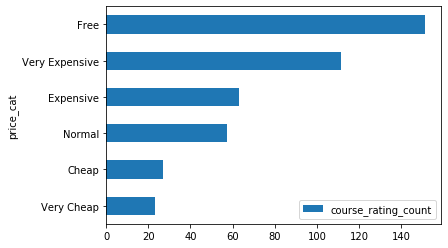

In [14]:
#First we create some price categories
chessable.loc[chessable['price'] == 0, 'price_cat'] = 'Free'
chessable.loc[(chessable['price'] > 0) & (chessable['price'] <= 10), 'price_cat'] = 'Very Cheap'
chessable.loc[(chessable['price'] > 10) & (chessable['price'] <= 20), 'price_cat'] = 'Cheap'
chessable.loc[(chessable['price'] > 20) & (chessable['price'] <= 30), 'price_cat'] = 'Normal'
chessable.loc[(chessable['price'] > 30) & (chessable['price'] <= 40), 'price_cat'] = 'Expensive'
chessable.loc[chessable['price'] > 40, 'price_cat'] = 'Very Expensive'

rating_count_pivot('price_cat')

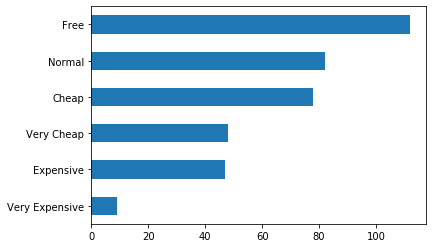

In [15]:
chessable.price_cat.value_counts().sort_values().plot.barh() #This counts the amount of courses

### Price conclusion
The results are quite interesting. We see that the more expensive a course becomes the more people are going to buy it, except in the case of a free course. Therefore I would recommend to price a course above the €30 at least. But I would almost recommend to set the price to over €40 if you have made a decent course. Although the sample size is small for the `Very Expensive` category. In order to be safe I would recommend most authors to go up a level or two in price. 

In connection with our correlation matrix we can also see that price correlates with expert and advanced level. However later we see in the visualization that the advanced and expert level actually receive the least ratings. The categories casual and intermediate should be the area to focus on if making money is the goal of the course.

## Recursive feature elimination
Right now it is time to use a decision tree model to select the features which are the most useful for predicting the course_rating_count. There will be a lot happening under the hood of the RFECV function. Basically it will train a few models and select the columns which give the most information gain. 

Information gain is quite easy to grasp in a decision tree let's consider the following case:
![img](https://miro.medium.com/max/820/0*LHzDR-s89Ggfqn7p.png)

Here the decision tree tries to find out if someone is fit. We can intuitively grasp that eating pizza is not giving the most information gain. Someone can be over 70 and not do morning exercises while not eating pizza. Then the person would still not be fit. So the feature that is put first to optimize the model gives the most information gain. 

Those will be displayed in the ranking in the following function.

In [16]:
#First we need to convert our categorical columns to dummy columns
def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    df = create_dummies(df,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

final = chessable
final = create_dummies(final, "titled_author")
final = create_dummies(final, "price_cat")
final = create_dummies(final, "section")
final = create_dummies(final, "target_color")

In [17]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing

#shuffling the dataframe a bit
chessable = chessable.sample(frac=1).reset_index(drop=True)

#Splitting in a feature and target 
final = final.dropna(axis=1).select_dtypes(include=np.number)
target = chessable['course_rating_count']
final = final.drop('course_rating_count', axis=1)

#Here we normalize the values, which is practical for linear_regression later
x = final.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
final = pd.DataFrame(x_scaled, columns=final.columns)

rf = RandomForestRegressor(random_state = 1, n_jobs = -1) #making results reproducible
selector = RFECV(rf, cv=5, n_jobs = -1)
selector.fit(final, target)

print(pd.concat([pd.Series(final.columns), pd.Series(selector.ranking_)],axis=1)) #This creates an inclusion score. 1 is inclusion.

                            0   1
0                       price   5
1               course_rating   8
2                      rubies   2
3                   beginning  17
4                      casual  15
5                intermediate  33
6                    advanced  27
7                      expert  23
8      instruction_word_count   4
9        trainable_variations   3
10             avg_line_depth   1
11         free_video_minutes   7
12               type_Endgame   9
13       type_Endgame/Tactics  40
14               type_Opening  18
15       type_Opening/Tactics  30
16              type_Strategy  38
17      type_Strategy/Endgame  41
18      type_Strategy/Opening  43
19      type_Strategy/Tactics  24
20               type_Tactics  10
21       type_Tactics/Endgame  37
22       type_Tactics/Opening  29
23      type_Tactics/Strategy  36
24           titled_author_CM  39
25           titled_author_FM  32
26           titled_author_GM  20
27           titled_author_IM  11
28          ti

With random forests we are getting a slightly clearer image of which columns to include. 
**important** these features only help well in predicting the course_rating_count. It does not mean that e.g. advanced courses sell well. It can also mean that they sell awfully.

In [18]:
mask = selector.support_ #now we can see which columns are supported
print([b for a, b in zip(mask, final.columns) if a])

['avg_line_depth']


In [19]:
#Let's see what linear regression does.
lr = LinearRegression(n_jobs = -1)
selector = RFECV(lr, cv=5, n_jobs = -1)
selector.fit(final, target)

print(pd.concat([pd.Series(final.columns), pd.Series(selector.ranking_)],axis=1))

                            0   1
0                       price  17
1               course_rating  31
2                      rubies  20
3                   beginning  42
4                      casual  38
5                intermediate  26
6                    advanced  43
7                      expert  41
8      instruction_word_count  19
9        trainable_variations  25
10             avg_line_depth  40
11         free_video_minutes  39
12               type_Endgame  21
13       type_Endgame/Tactics  28
14               type_Opening  24
15       type_Opening/Tactics  35
16              type_Strategy  34
17      type_Strategy/Endgame  27
18      type_Strategy/Opening  29
19      type_Strategy/Tactics  22
20               type_Tactics  23
21       type_Tactics/Endgame  36
22       type_Tactics/Opening  18
23      type_Tactics/Strategy  30
24           titled_author_CM  11
25           titled_author_FM  12
26           titled_author_GM  13
27           titled_author_IM  15
28          ti

## Conclusions feature selection
I would not trust this data too much because linear regression is very sensitive to outliers. Well, unfortunately we do not have a lot of information. We need to see how the models are scoring to draw a conclusion.

In [20]:
from sklearn.model_selection import cross_val_score

#Here we take the mean absolute error, which means how much the model was off on average. 
#Here we should have dropped rubies and ratings if this model would be trained for other goals than feature selection.
print('LinearRegression:', cross_val_score(lr,final,target, scoring = 'neg_mean_absolute_error'))
print('Random Forests:', cross_val_score(rf,final,target, scoring = 'neg_mean_absolute_error'))
print('Random Forests with selected cols:', cross_val_score(rf,final[['price', 'advanced', 'instruction_word_count', 'trainable_variations', 'avg_line_depth', 'free_video_minutes', 'type_Endgame/Tactics', 'type_Strategy', 'titled_author_FM', 'price_cat_Very Cheap', 'target_color_black pieces', 'target_color_white pieces']],target, scoring = 'neg_mean_absolute_error'))
print('LinearRegression with selected cols:', cross_val_score(lr,final[['price','advanced','type_Endgame','price_cat_Free','price_cat_Very Expensive','titled_author_IM']],target, scoring = 'neg_mean_absolute_error'))

LinearRegression: [ -78.6712236   -74.53868135  -67.31333333 -102.83767045 -106.66217016]
Random Forests: [-130.52947368  -63.87133333  -78.69733333 -109.58386667  -87.7268    ]
Random Forests with selected cols: [-143.82657895  -67.8284      -82.5644     -110.62213333  -81.0688    ]
LinearRegression with selected cols: [-72.32449453 -68.45700504 -68.41241961 -99.19446003 -85.62389504]


## Machine learning conclusion
All in all the machine learning efforts have been in vain. The data is too sparse to draw very meaningful conclusions. The Random forest selected features are improving the model but nothing very meaningful. Linear Regression has also slightly improved, but is still performing quite poor. 

That means that the correlation is not obvious for a linear model. For example a variable like average variation depth does not tell us that much. Neither does price. On the other hand, all together they are much more able to predict the rating count. 

This means that every feature is around equally important for estimating the end result. There is no real golden metric to adhere for prediction if we ask the computer. 

The takeaways from the exploratory data analysis are the following:
* Courses for White sell better than for Black or both colors.
* Courses for Casual and Intermediate players are the most popular.
* There is a clear correlation between price and course level. 
* The more expensive a course is the more ratings it has.
* The IM's score better than the other titles concerning rating_counts.
* We **definitely** need more data to draw better conclusions from machine learning.

# Focusing on revenue
From now on we will drop the free-part of the dataset in order to see if the findings for the popularity which now most definitely means revenue. After some neat visualizations I will draw some final conclusions.

In [21]:
pd.set_option('display.max_columns', 500)
chessable.head()

,course_link,course_title,course_type,author,price,price_with_video,course_rating,course_rating_count,rubies,target_color,beginning,casual,intermediate,advanced,expert,language,instruction_word_count,trainable_variations,avg_line_depth,released_on,support_level,section,free_video_minutes,titled_author,type_Endgame,type_Endgame/Tactics,type_Opening,type_Opening/Tactics,type_Strategy,type_Strategy/Endgame,type_Strategy/Opening,type_Strategy/Tactics,type_Tactics,type_Tactics/Endgame,type_Tactics/Opening,type_Tactics/Strategy,price_cat
0,chess-tactics-from-scratch-understanding-chess...,Chess Tactics from Scratch - Understanding Che...,Tactics,FM Martin Weteschnik & Quality Chess,31.5,31.5,4.4,27,53,both pieces,0,1,1,1,0,English,70330,629,4.02,2019-09-27,Community,Publisher,0,FM,0,0,0,0,0,0,0,0,1,0,0,0,Expensive
1,beat-bad-pesky-openings/course/29117/,Beat Bad & Pesky Openings,Opening,"InfiniteFlash (2300 Online Rating, 2100 USCF)",0.0,NaN,4.6,26,84,both pieces,1,1,1,1,1,No language,4009,71,8.64,2020-05-28,Unspecified,Community,0,no title,0,0,1,0,0,0,0,0,0,0,0,0,Free
2,the-magnus-touch-free-strategy-lesson/course/4...,The Magnus Touch: Free Strategy Lesson,Strategy/Tactics,"GM Nielsen, IM Sielecki, IM Bartholomew & GM M...",0.0,NaN,4.4,130,249,both pieces,0,0,1,1,1,English,2618,12,5.23,2020-05-08,High,Titled player,27,GM,0,0,0,0,0,0,0,1,0,0,0,0,Free
3,learn-chess-the-right-way-book-1-must-know-che...,Learn Chess the Right Way - Book 1: Must-know ...,Tactics,GM Susan Polgar & Russell Enterprises,21.0,21.0,4.5,96,50,both pieces,1,1,0,0,0,English,5263,498,1.12,2018-06-18,Community,Publisher,0,GM,0,0,0,0,0,0,0,0,1,0,0,0,Normal
4,short-sweet-the-kings-indian-attack/course/27065/,Short & Sweet: The King's Indian Attack,Opening,"FM Kamil Plichta (3129 Online Rating, 2361 FIDE)",0.0,NaN,4.7,140,109,white pieces,0,1,1,1,1,No language,6540,26,15.82,2019-08-27,High,Titled player,125,FM,0,0,1,0,0,0,0,0,0,0,0,0,Free


In [22]:
paid = chessable[chessable['price'] != 0]
paid.shape

(264, 37)

In [23]:
import warnings
warnings.filterwarnings("ignore")
#We have lost 110 courses in the process. Let's see who the most succesful authors are!
#Creatig a revenue column without the rubies, they go to chessable, not the author.
paid['revenue'] = paid['course_rating_count'] * paid['price']
author_pivot = pd.pivot_table(paid, values = ['revenue', 'rubies'], index='author', aggfunc='sum')
author_pivot = author_pivot.sort_values('revenue', ascending = False).head(20)

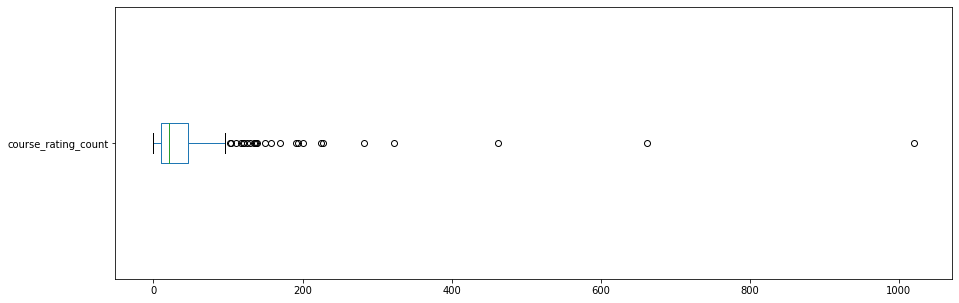

In [24]:
paid.course_rating_count.plot.box(figsize=(15,5),vert=False) #checking the distribution. It's still the same as above

Text(0.5, 1.0, 'The top revenue authors on chessable.com')

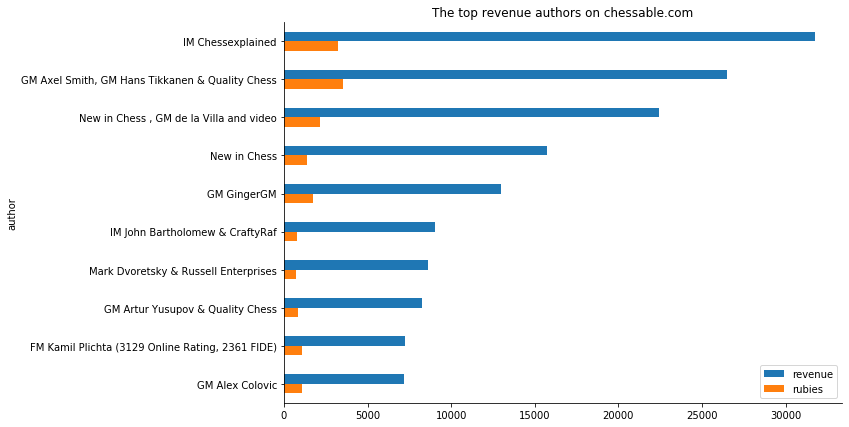

In [25]:
import seaborn as sns
author_pivot[:10].plot.barh(figsize=(10,7))
sns.despine()
plt.gca().invert_yaxis()
plt.title(label = 'The top revenue authors on chessable.com')

In the top we do see more grandmasters than other titled players. This shows that GM's can make more money. Let's try to confirm that.

In [26]:
author_pivot = pd.pivot_table(paid, values = ['revenue'], index='titled_author', aggfunc='sum')
author_pivot = author_pivot.sort_values('revenue', ascending = False)
author_pivot

,revenue
titled_author,
GM,103476.62
no title,89089.19
IM,69652.26
FM,31328.61
CM,2072.36
WIM,954.00
WFM,758.67


The original order of titles has been confirmed, at least in the sums of who made the most in all courses on the platform. 
The no-titles are actually mostly publishers publishing their books on the platform. One of them is Mark Dvoretsky, who is actually a GM as well. It shows nicely the complete amounts of money to be made. Although not everyone has given a rating of course.

Text(0.5, 1.0, 'Chess titles and Revenue percentage on Chessable.com')

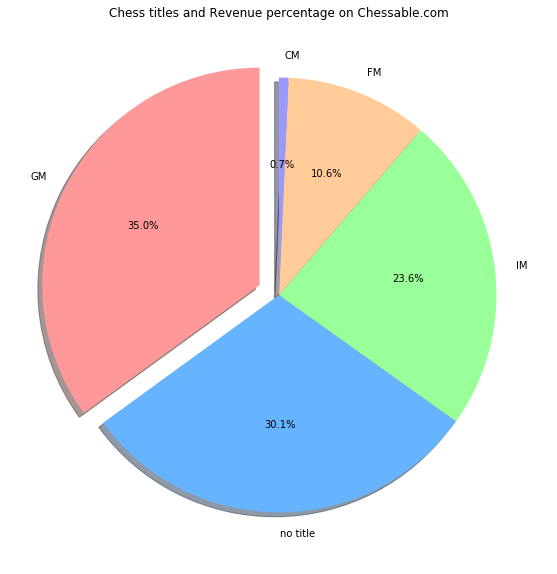

In [27]:
author_pivot = author_pivot.iloc[0:5,:]
explode = (0.1,0,0,0,0)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#9999ff']
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(author_pivot['revenue'],explode=explode, labels = author_pivot.index, autopct='%1.1f%%', colors=colors, shadow=True, startangle = 90)
plt.title(label="Chess titles and Revenue percentage on Chessable.com")

## Payment per move
Let's see which price category gets paid best per move! We can divide revenue by move count, to see the tradeoff between work and revenue. Later we can do a similar thing for payment per word. 

In [28]:
price_pivot = pd.pivot_table(paid, values = ['revenue','trainable_variations','avg_line_depth'], index='price_cat')
price_pivot['moves'] = price_pivot['trainable_variations'] * price_pivot['avg_line_depth'] #variations*depth is total moves
price_pivot['revenue_per_move'] = price_pivot['revenue'] / price_pivot['moves'] #And we can even see the revenue per move! 
price_pivot = price_pivot.sort_values('revenue',ascending=False)
price_pivot

,avg_line_depth,revenue,trainable_variations,moves,revenue_per_move
price_cat,,,,,
Very Expensive,13.004444,5098.776667,676.111111,8792.449383,0.579904
Expensive,11.838511,2185.850000,453.191489,5365.112268,0.407419
Normal,10.520122,1367.932805,424.085366,4461.429767,0.306613
Cheap,12.084231,376.847949,375.179487,4533.755503,0.083120
Very Cheap,11.731667,148.815417,117.770833,1381.648160,0.107709


Text(0, 0.5, '')

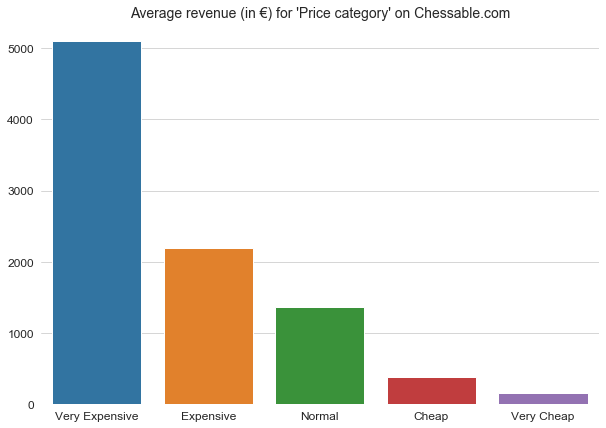

In [29]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,7))
sns.barplot(x= price_pivot.index, y= price_pivot['revenue'])
plt.title(label = "Average revenue (in €) for 'Price category' on Chessable.com", fontsize=14)
sns.despine(left=True,bottom=True)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("")

The very expensive category makes a lot more money per course than the other categories. Another recommendation to make courses as expensive as you can. However, as we can see below, the amount of effort for the expensive courses is higher than for the normal courses.

Text(0, 0.5, '')

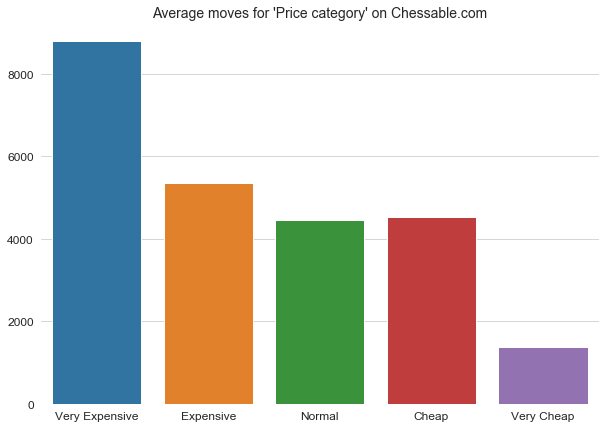

In [30]:
plt.figure(figsize=(10,7))
sns.barplot(x= price_pivot.index, y= price_pivot['moves'])
plt.title(label = "Average moves for 'Price category' on Chessable.com", fontsize=14)
sns.despine(left=True,bottom=True)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("")

Text(0, 0.5, '')

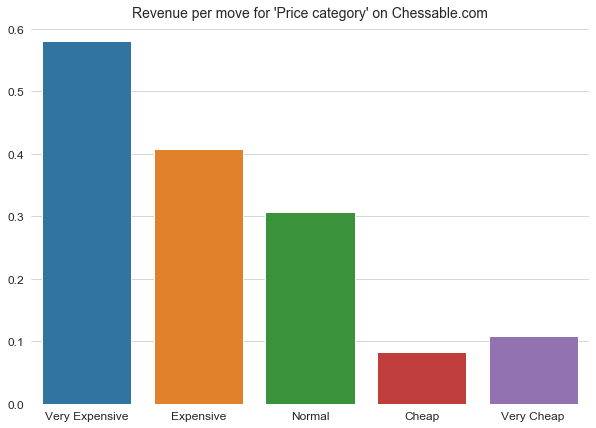

In [31]:
plt.figure(figsize=(10,7))
sns.barplot(x= price_pivot.index, y= price_pivot['revenue_per_move'])
plt.title(label = "Revenue per move for 'Price category' on Chessable.com", fontsize=14)
sns.despine(left=True,bottom=True)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("")

## Conclusions revenue per move
* We can still see that the revenue per move for the very expensive courses is the highest. However, do realize it is a high risk high reward strategy. 
* The absolute amount of moves for the middle three categories is around the same, however this really affects the revenue per move. **Expensive generally seems to be the best category to aim for**
* One is ill advised to price the course between the 10 and 20 €. This gives the lowest revenue per move.
* Another thing we can say is that it is better to generate a lot of very cheap courses than to price a normal course cheaply. 
* One big side-note here is that *Title most likely influences this result*. But generally if one puts in a great amount of effort, one can ask a great amount of money!

## Revenue for course types
A next investigation is to see what the revenue per move is for course types. Should we focus more on tactics or more on openings for example.

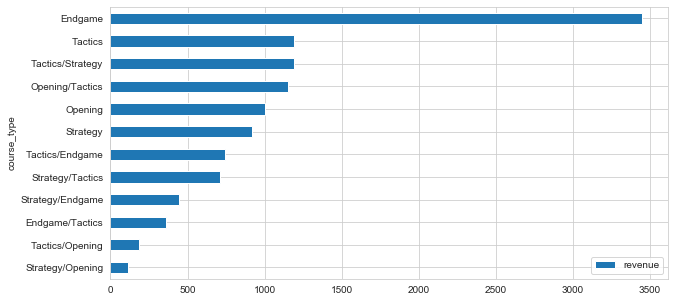

In [34]:
type_pivot = pd.pivot_table(paid,values='revenue',index='course_type').sort_values('revenue')
type_pivot.plot.barh(figsize=(10,5))

## Course type conclusions
The reason for Endgame being the prominent category here is that there are some timeless classics about the endgame in chess that everyone knows. whereas openings are much more dependent on computer analysis et cetera. One of the markets that seems promising is the opening/tactics one. People like to get to know more about opening tricks. And that is quite easy to make. Currently there does not seems to be any comprehensive course like it. 

Another observation to make is that strategy courses payoff the worst. That is because strategy is quite an advanced subject, and we can clearly say that the market is best for casual and intermediate players. And therefore slightly worse for strategy. 

Two interesting ideas:
* A practical endgame course for intermediate players with some simple variations.
* Opening traps categorized by theme instead of opening. That is because tactics is more popular than openings.